Import packages

In [37]:
import tensorflow as tf
import create_dataset
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Define generic functions to visualize data

In [38]:
def showImage(im):
    if (im.shape[2] == 1):
        im = im[:, :, 0]
    plt.imshow(im)
    plt.show()

Define generic functions to initialize weight/bias variables, and to define common convolution and pooling operations

In [39]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial, name='weights')

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial, name='biases')

In [40]:
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

Define the network architecture + loss function and metrics

In [51]:
# Input/Output placeholders
x = tf.placeholder(tf.float32, shape=[None, 28, 28, 1], name='input')
y_ = tf.placeholder(tf.float32, shape=[None, 2], name='output')

num_fc_layers = 10
print x_image.shape

# Layer 1
with tf.name_scope('1/Conv'):
    W_conv1 = weight_variable([3, 3, 1, 32])
    b_conv1 = bias_variable([32])
    x_image = tf.reshape(x, [-1, 28, 28, 1])
    h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
    h_pool1 = max_pool_2x2(h_conv1)

print h_pool1.shape

# Layer 2
with tf.name_scope('2/Conv'):
    W_conv2 = weight_variable([3, 3, 32, 64])
    b_conv2 = bias_variable([64])
    h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
    h_pool2 = max_pool_2x2(h_conv2)

print h_pool2.shape

layers = [tf.reshape(h_pool2, [-1, 7*7*64])]
keep_prob = tf.placeholder(tf.float32)
prev_layer_size = 7*7*64                     
# Create FC layers
for i in range(0, num_fc_layers):
    with tf.name_scope('{}/FC'.format(i)):
        W_fc = weight_variable([prev_layer_size, 1024])
        b_fc = bias_variable([1024])
        if i < num_fc_layers/3:
            h_fc = tf.nn.relu(tf.matmul(layers[-1], W_fc) + b_fc)
        else: 
            h_fc = tf.nn.tanh(tf.matmul(layers[-1], W_fc) + b_fc)
        h_fc_drop = tf.nn.dropout(h_fc, keep_prob)
        layers.append(h_fc_drop)
        prev_layer_size = 1024

# Readout
with tf.name_scope('5/Readout'):
    W_fc2 = weight_variable([1024, 2])
    b_fc2 = bias_variable([2])
    y_conv = tf.matmul(layers[-1], W_fc2) + b_fc2
    norm_y_conv = tf.nn.l2_normalize(y_conv, dim=0)

# Define loss
l2_loss = tf.reduce_mean(
    tf.nn.l2_loss(tf.subtract(norm_y_conv, y_)) + 0.01*tf.nn.l2_loss(tf.subtract(norm_y_conv, y_conv)))
train_step = tf.train.AdamOptimizer(1e-5).minimize(l2_loss)

(?, 28, 28, 1)
(?, 14, 14, 32)
(?, 7, 7, 64)


Train the network per-batch

step 0, training loss 0.446005
step 20, training loss 0.664703
step 40, training loss 0.454936
step 60, training loss 0.287627
step 80, training loss 0.283159
step 100, training loss 0.143736
step 120, training loss 0.303845
step 140, training loss 0.212917
step 160, training loss 0.243339
step 180, training loss 0.198749
step 200, training loss 0.351385
step 220, training loss 0.201772
step 240, training loss 0.254066
step 260, training loss 0.190797
step 280, training loss 0.384284
step 300, training loss 0.265098
step 320, training loss 0.225428
step 340, training loss 0.191294
step 360, training loss 0.214714
step 380, training loss 0.378821
step 400, training loss 0.22326
step 420, training loss 0.277569
step 440, training loss 0.284007
step 460, training loss 0.17876
step 480, training loss 0.192146
step 500, training loss 0.189788
step 520, training loss 0.272541
step 540, training loss 0.276438
step 560, training loss 0.166713
step 580, training loss 0.180553
step 600, training

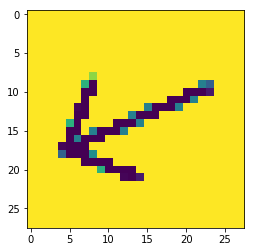

True angle: 204
True sin/cos: [-0.40673664 -0.91354546]
Predicted angle: [-0.53031498 -0.25976476]


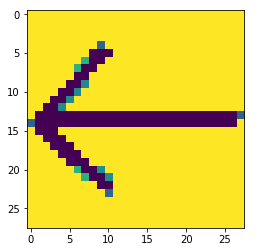

True angle: 181
True sin/cos: [-0.01745241 -0.9998477 ]
Predicted angle: [ 0.06591949 -0.56909788]


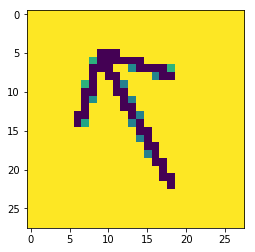

True angle: 118
True sin/cos: [ 0.88294759 -0.46947156]
Predicted angle: [ 0.33469728 -0.44882503]


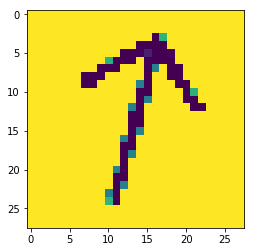

True angle: 75
True sin/cos: [ 0.96592583  0.25881905]
Predicted angle: [ 0.59835076  0.63808542]


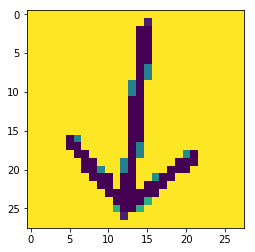

True angle: 264
True sin/cos: [-0.9945219  -0.10452846]
Predicted angle: [-0.49434274 -0.00726104]


In [54]:
batch_size = 5
logging_frequency = 20
iterations = 800

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(iterations):
    batch = create_dataset.generate_data(batch_size)
    if i % logging_frequency == 0:
      loss = sess.run(l2_loss, feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0}) 
      print('step %d, training loss %g' % (i, loss/batch_size))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 1.0})
    
  visualization_size = 5
  vis_batch = create_dataset.generate_data(visualization_size)
  output = sess.run(norm_y_conv, feed_dict={x: vis_batch[0], y_: vis_batch[1], keep_prob: 1.0})
  for i in range(visualization_size):
    showImage(vis_batch[0][i])
    print ("True angle: " + str(vis_batch[2][i][0]))
    print ("True sin/cos: " + str(vis_batch[1][i]))
    print ("Predicted angle: " + str(output[i]))